<a href="https://colab.research.google.com/github/DoItSon/playdata/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%ED%95%B4%EB%B3%B4%EA%B8%B0!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 메모장
- 0.8189379090413184 = 0.5
- 0.8236173245493615 = 0.4
- 0.8236625863676823 = 0.3
- 0.8256464235755943 = 0.35

- 0.823185924948775 머신러닝 결측치
- 0.8247486240372479 내 결측치

- 추후 베이지안 최저화를 통해 최적의 파라미터 찾기!

In [900]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectPercentile

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier,plot_importance
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings(action='ignore') 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [901]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [902]:
import optuna

In [903]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [904]:
DATA_PATH = "/content/drive/MyDrive/"

In [905]:
train = pd.read_csv(f'{DATA_PATH}train.csv')
test = pd.read_csv(f'{DATA_PATH}test.csv')

In [906]:
categorical_features_enc = ['COMPONENT_ARBITRARY_COMPONENT1',
       'COMPONENT_ARBITRARY_COMPONENT2', 'COMPONENT_ARBITRARY_COMPONENT3',
       'COMPONENT_ARBITRARY_COMPONENT4', 'YEAR_2007', 'YEAR_2008', 'YEAR_2009',
       'YEAR_2010', 'YEAR_2011', 'YEAR_2012', 'YEAR_2013', 'YEAR_2014',
       'YEAR_2015', 'YEAR_2016', 'YEAR_2017', 'YEAR_2018', 'YEAR_2019',
       'YEAR_2020', 'YEAR_2021', 'YEAR_2022']

## 전처리

In [907]:
CFG = {
    'n_splits':5,
    'SEED':42
}

- 내가 직접한 결측치

In [908]:
# fill_mean_func = lambda x: x.fillna(x.median())
# zx = train.groupby(["SAMPLE_TRANSFER_DAY","COMPONENT_ARBITRARY"]).apply(fill_mean_func)
# xc = zx.groupby(["ANONYMOUS_2","YEAR"]).apply(fill_mean_func)

# xc1 = xc.groupby(["ANONYMOUS_1","ANONYMOUS_2"]).apply(fill_mean_func)

# feat = pd.DataFrame(train["ID"].unique(),columns = ["ID"])

# xc2 = xc1.groupby(["MO"]).apply(fill_mean_func)

# features = feat.merge(xc2,how="left",on="ID")

# train = features

In [909]:
# train.isnull().sum()

- 머신러닝

In [910]:
cols = ['CD','FOPTIMETHGLY',"FUEL",'K','U100','U75','U50',"FH2O","FNOX","FOXID","FSO4","FTBN","SOOTPERCENTAGE","U25","U20","U14","U6","U4","V100"]

In [911]:
from sklearn.linear_model import LinearRegression
for i in cols:
    imputer = IterativeImputer(estimator =  lgb.LGBMRegressor(),random_state=CFG["SEED"]) # IterativeImputer에서 다양한 옵션이 있다. (estimator는 머신러닝 옵션!)
    train[i] = imputer.fit_transform(train[[i]])

- 다 0으로 채우기!

In [912]:
# train = train.fillna(0)
# test = test.fillna(0)

In [913]:
train.isnull().sum().sum()

0

In [914]:
train.columns

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR',
       'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CD', 'CO', 'CR', 'CU', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4',
       'FTBN', 'FE', 'FUEL', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI',
       'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'TI',
       'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V', 'V100',
       'V40', 'ZN', 'Y_LABEL'],
      dtype='object')

## 피처 추가

In [915]:
# reg_col = ['AL', 'B', 'BA', 'BE', 'CA',
#        'CD', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4',
#        'FTBN', 'FUEL', 'K', 'LI', 'MG', 'NA',
#        'P', 'PB',  'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE',
#        'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V100',
#        ] # 'ID','YEAR','ANONYMOUS_2','COMPONENT_ARBITRARY' train에만 있는 것

In [916]:
# tmp = train.groupby(["COMPONENT_ARBITRARY","ANONYMOUS_1","ANONYMOUS_2","YEAR"])[reg_col].mean()
# tmp = tmp.reset_index()
# tmp = tmp.add_prefix("mean_")
# tmp = tmp.rename(columns = {'mean_COMPONENT_ARBITRARY':'COMPONENT_ARBITRARY','mean_ANONYMOUS_1':'ANONYMOUS_1','mean_ANONYMOUS_2':'ANONYMOUS_2','mean_YEAR':'YEAR'})
# tmp

In [917]:
# test = test.merge(tmp,how="left",on = ["COMPONENT_ARBITRARY","ANONYMOUS_1","ANONYMOUS_2","YEAR"])
# test

## 피처추가

In [918]:
# features = pd.DataFrame(train["ID"].unique(),columns=["ID"])
# features.head()

In [919]:
# tmp = pd.pivot_table(
#     train, # 대상이 되는 데이터 프레임
#     index = ["ID","ANONYMOUS_1","ANONYMOUS_2","YEAR"],
#     values = reg_col,
#     aggfunc = np.mean 
# ) 
# tmp

In [920]:
# train = train.merge(tmp,how="left",on = ["ID"])
# train

## 데이터 분리

In [921]:
train_X  = train.drop(['ID', 'Y_LABEL'], axis = 1) # 정답값 제외
target  = train['Y_LABEL'] # 정답

test = test.drop(['ID'], axis = 1) # 추론 데이터

In [922]:
train_X

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,...,U50,U25,U20,U14,U6,U4,V,V100,V40,ZN
0,COMPONENT3,1486,2011,7,200,0,3,93,0,0,...,6.185233,29.870898,56.063472,239.938149,5488.693107,19415.597262,0,13.57623,154.0,75
1,COMPONENT2,1350,2021,51,375,0,2,19,0,0,...,1.000000,2.000000,4.000000,6.000000,216.000000,1454.000000,0,13.57623,44.0,652
2,COMPONENT2,2415,2015,2,200,0,110,1,1,0,...,0.000000,0.000000,3.000000,39.000000,11261.000000,41081.000000,0,13.57623,72.6,412
3,COMPONENT3,7389,2010,2,200,0,8,3,0,0,...,6.185233,29.870898,56.063472,239.938149,5488.693107,19415.597262,0,13.57623,133.3,7
4,COMPONENT3,3954,2015,4,200,0,1,157,0,0,...,6.185233,29.870898,56.063472,239.938149,5488.693107,19415.597262,0,13.57623,133.1,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,COMPONENT3,1616,2014,8,200,0,2,201,1,0,...,6.185233,29.870898,56.063472,239.938149,5488.693107,19415.597262,0,13.57623,135.4,16
14091,COMPONENT1,2784,2013,2,200,0,3,85,0,0,...,6.185233,29.870898,56.063472,239.938149,5488.693107,19415.597262,0,14.50000,117.5,1408
14092,COMPONENT3,1788,2008,9,550,0,6,0,1,0,...,6.185233,29.870898,56.063472,239.938149,5488.693107,19415.597262,0,13.57623,54.0,1301
14093,COMPONENT2,2498,2009,19,550,0,2,4,0,0,...,0.000000,7.000000,8.000000,100.000000,1625.000000,18890.000000,0,13.57623,44.3,652


# 원핫인코딩

In [923]:
enc = OneHotEncoder()

tmp = pd.DataFrame(
    enc.fit_transform(train_X[["COMPONENT_ARBITRARY",'YEAR']]).toarray(),
    columns = enc.get_feature_names_out()
)
train_X = pd.concat([train_X,tmp],axis=1).drop(columns = ["COMPONENT_ARBITRARY",'YEAR'])

tmp1 = pd.DataFrame(
    enc.transform(test[["COMPONENT_ARBITRARY",'YEAR']]).toarray(),
    columns = enc.get_feature_names_out()
)
test = pd.concat([test,tmp1],axis=1).drop(columns = ["COMPONENT_ARBITRARY",'YEAR'])

In [924]:
train_X.shape,target.shape,test.shape

((14095, 70), (14095,), (6041, 36))

# 스케일링

In [925]:
def get_values(value):
    return value.values.reshape(-1, 1)

for col in train_X.columns:
    if col not in categorical_features_enc:
        scaler = StandardScaler()
        train_X[col] = scaler.fit_transform(get_values(train_X[col]))
        if col in test.columns:
            test[col] = scaler.transform(get_values(test[col]))

## Classifier

In [926]:
def objective_1(trial):
    hp = {
        "max_depth" : trial.suggest_int("max_depth",2,15), # 찾을 범위의 최소값과 최대값
        "min_samples_split" : trial.suggest_int("min_samples_split",2,10),
        "criterion" : trial.suggest_categorical("criterion",["gini","entropy"]),
        "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes",5,10),
        "n_estimators" : trial.suggest_int("n_estimators",10,500),
        "learning_rate" : trial.suggest_float("learning_rate",0.01,0.1)
    }
    cv = KFold(n_splits=5,shuffle=True,random_state=CFG['SEED'])
    model = LGBMClassifier(random_state=CFG['SEED'],**hp)

    scores = cross_val_score(model, train_X, target,cv=cv, scoring="f1_macro") # cv=cv 지움!
    return np.mean(scores)

In [927]:
sampler = optuna.samplers.TPESampler(seed = CFG['SEED']) 

study_1 = optuna.create_study(
    direction= "maximize", 
    sampler = sampler
)

study_1.optimize(objective_1,n_trials=50)

[I 2022-11-29 12:52:07,232] A new study created in memory with name: no-name-f67633a0-195b-4444-b6aa-8b18c36c9d2c
[I 2022-11-29 12:52:13,199] Trial 0 finished with value: 0.8106363536714513 and parameters: {'max_depth': 7, 'min_samples_split': 10, 'criterion': 'gini', 'max_leaf_nodes': 5, 'n_estimators': 86, 'learning_rate': 0.015227525095137952}. Best is trial 0 with value: 0.8106363536714513.
[I 2022-11-29 12:52:41,680] Trial 1 finished with value: 0.8200270878135774 and parameters: {'max_depth': 14, 'min_samples_split': 7, 'criterion': 'gini', 'max_leaf_nodes': 10, 'n_estimators': 418, 'learning_rate': 0.029110519961044856}. Best is trial 1 with value: 0.8200270878135774.
[I 2022-11-29 12:52:45,478] Trial 2 finished with value: 0.8156562395084302 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy', 'max_leaf_nodes': 7, 'n_estimators': 152, 'learning_rate': 0.06506676052501416}. Best is trial 1 with value: 0.8200270878135774.
[I 2022-11-29 12:52:47,903] Tr

In [929]:
print("Best Score:",study_1.best_value) 
print("Best hp", study_1.best_params)

Best Score: 0.8240021221452623
Best hp {'max_depth': 15, 'min_samples_split': 2, 'criterion': 'entropy', 'max_leaf_nodes': 10, 'n_estimators': 495, 'learning_rate': 0.0943448646911196}


In [928]:
study_1.best_params # 따로 적어놓기

{'max_depth': 15,
 'min_samples_split': 2,
 'criterion': 'entropy',
 'max_leaf_nodes': 10,
 'n_estimators': 495,
 'learning_rate': 0.0943448646911196}

In [780]:
# hp = {'max_depth': 7,
#     'min_samples_split': 8,
#     'criterion': 'gini',
#     'max_leaf_nodes': 5,
#     'n_estimators': 393,
#     'learning_rate': 0.029558584406711337}

In [930]:
hp = {'max_depth': 15,
 'min_samples_split': 2,
 'criterion': 'entropy',
 'max_leaf_nodes': 10,
 'n_estimators': 495,
 'learning_rate': 0.0943448646911196}

In [781]:
# hp = {'max_depth': 8,
# 'min_samples_split': 7,
# 'criterion': 'gini',
# 'max_leaf_nodes': 9,
# 'n_estimators': 495,
# 'learning_rate': 0.07171518532882763}

In [931]:
cv = KFold(n_splits=5,shuffle=True,random_state=CFG["SEED"])

In [932]:
score_list = []

model = LGBMClassifier(random_state=CFG['SEED'],**hp,use_missing=False) # use_missing=False 결측치 옵션
model.fit(train_X,target , eval_set = [(train_X,target)],early_stopping_rounds=50) 

pred = model.predict_proba(train_X)[:,1] # 1일 확률

predict = np.where(pred > 0.35, 1 , 0)
score = cross_val_score(model,train_X,target,cv = cv ,scoring='f1_macro',n_jobs = -1)
score_list.append(score) 

[1]	training's binary_logloss: 0.24549
Training until validation scores don't improve for 50 rounds.
[2]	training's binary_logloss: 0.2257
[3]	training's binary_logloss: 0.211774
[4]	training's binary_logloss: 0.201091
[5]	training's binary_logloss: 0.192236
[6]	training's binary_logloss: 0.184739
[7]	training's binary_logloss: 0.17803
[8]	training's binary_logloss: 0.172338
[9]	training's binary_logloss: 0.167164
[10]	training's binary_logloss: 0.162448
[11]	training's binary_logloss: 0.158308
[12]	training's binary_logloss: 0.15461
[13]	training's binary_logloss: 0.15099
[14]	training's binary_logloss: 0.147402
[15]	training's binary_logloss: 0.144523
[16]	training's binary_logloss: 0.141779
[17]	training's binary_logloss: 0.138974
[18]	training's binary_logloss: 0.136404
[19]	training's binary_logloss: 0.134007
[20]	training's binary_logloss: 0.131818
[21]	training's binary_logloss: 0.129746
[22]	training's binary_logloss: 0.127656
[23]	training's binary_logloss: 0.125829
[24]	train

## 특성 중요도 확인하기

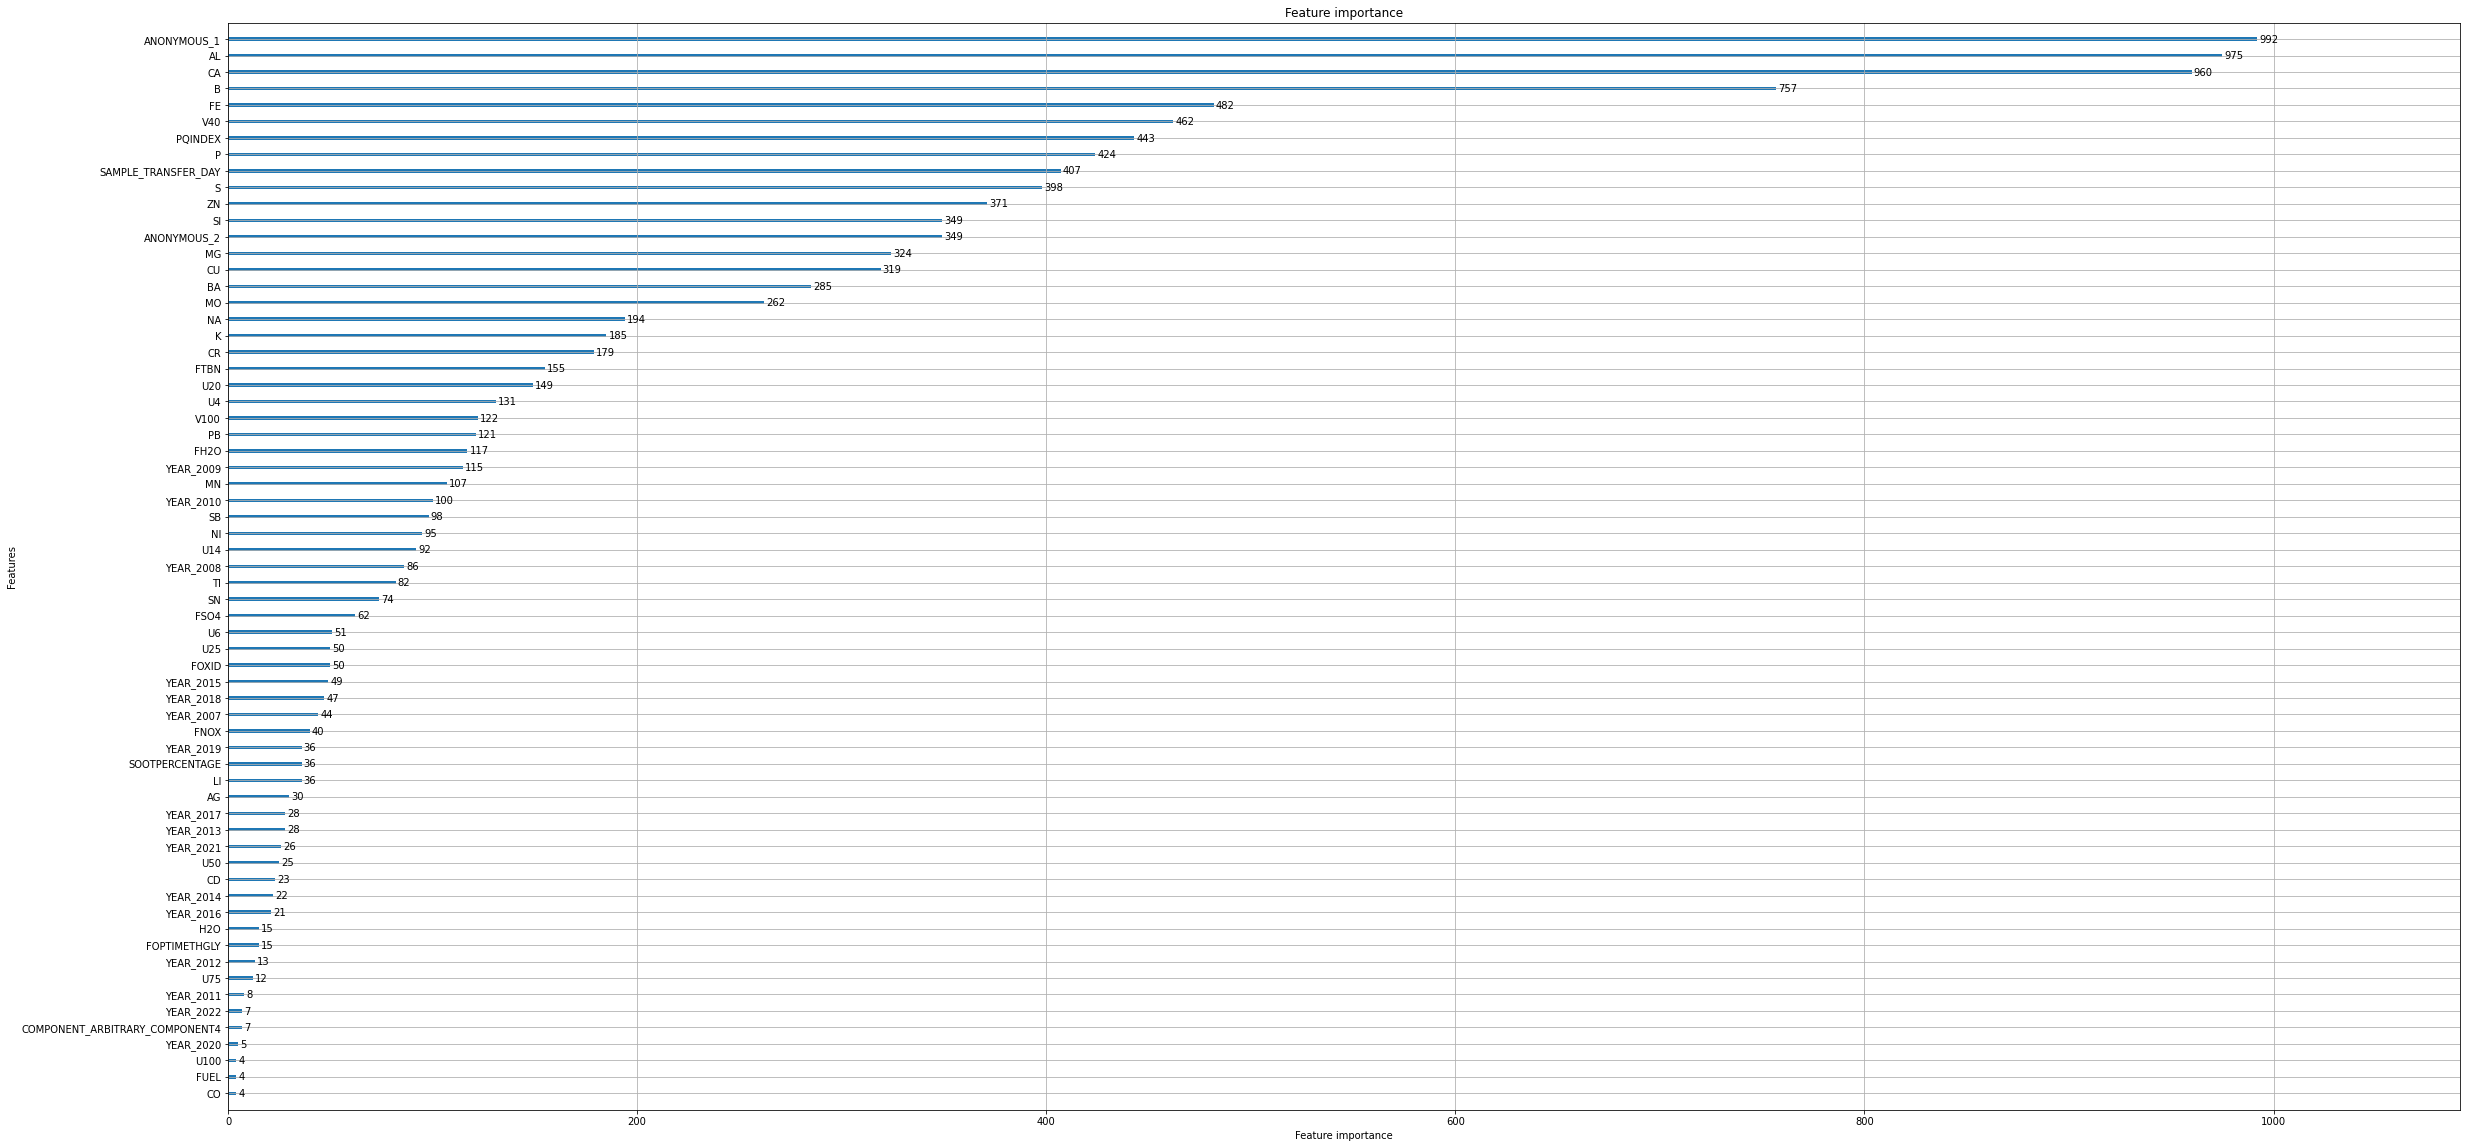

In [784]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(40,20))
plot_importance(model,ax=ax)
plt.show()

In [933]:
np.mean(score_list)
# 0.8224204057789853
# 0.8186300689616133 cross_val_score
# 0.8216393919007956 피처 추가
# 0.8226314153634704
# 0.8225201927199011
# 0.823229059917075 피처 추가 X
# 0.8205729340533052 mean

0.8240021221452623

In [934]:
x_target = pred
x_target

array([1.33592834e-04, 8.36161461e-04, 9.99903521e-01, ...,
       4.06441617e-02, 1.86754541e-03, 1.25559365e-04])

- 확률 추출!

In [787]:
# x_target = pd.DataFrame(pred)
# x_target = x_target.squeeze()
# x_target

## Regressor

- train의 부분 X의 예측값을 설명하는 Regressor

In [938]:
test_stage_features = ['ANONYMOUS_1', 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN',
       'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN',
       'COMPONENT_ARBITRARY_COMPONENT1', 'COMPONENT_ARBITRARY_COMPONENT2',
       'COMPONENT_ARBITRARY_COMPONENT3', 'COMPONENT_ARBITRARY_COMPONENT4',
       'YEAR_2007', 'YEAR_2008', 'YEAR_2009', 'YEAR_2010', 'YEAR_2011',
       'YEAR_2012', 'YEAR_2013', 'YEAR_2014', 'YEAR_2015', 'YEAR_2016',
       'YEAR_2017', 'YEAR_2018', 'YEAR_2019', 'YEAR_2020', 'YEAR_2021',
       'YEAR_2022']

In [939]:
train_reg = train_X[test_stage_features]
train_reg.shape,x_target.shape

((14095, 36), (14095,))

In [940]:
from lightgbm.sklearn import LGBMRegressor
def objective_2(trial):
    hp = {
        "max_depth" : trial.suggest_int("max_depth",2,15), # 찾을 범위의 최소값과 최대값
        "min_samples_split" : trial.suggest_int("min_samples_split",2,10),
        "criterion" : trial.suggest_categorical("criterion",["gini","entropy"]),
        "max_leaf_nodes" : trial.suggest_int("max_leaf_nodes",5,10),
        "n_estimators" : trial.suggest_int("n_estimators",10,500),
        "learning_rate" : trial.suggest_float("learning_rate",0.01,0.1)
    }
    cv = KFold(n_splits=5,shuffle=True,random_state=CFG['SEED'])
    model = LGBMRegressor(random_state=CFG['SEED'],**hp)

    scores = cross_val_score(model, train_reg, x_target,cv=cv ,scoring="neg_mean_absolute_error") # cv=cv 지움!
    return np.mean(scores)

In [941]:
sampler = optuna.samplers.TPESampler(seed = CFG['SEED']) 

study_1 = optuna.create_study(
    direction= "minimize", 
    sampler = sampler
)

study_1.optimize(objective_2,n_trials=50)

[I 2022-11-29 13:04:41,974] A new study created in memory with name: no-name-0498a6fa-53a3-4a66-a9c9-d79df1a83862
[I 2022-11-29 13:04:43,843] Trial 0 finished with value: -0.14777050763943217 and parameters: {'max_depth': 7, 'min_samples_split': 10, 'criterion': 'gini', 'max_leaf_nodes': 5, 'n_estimators': 86, 'learning_rate': 0.015227525095137952}. Best is trial 0 with value: -0.14777050763943217.
[I 2022-11-29 13:04:52,261] Trial 1 finished with value: -0.14434819901189808 and parameters: {'max_depth': 14, 'min_samples_split': 7, 'criterion': 'gini', 'max_leaf_nodes': 10, 'n_estimators': 418, 'learning_rate': 0.029110519961044856}. Best is trial 0 with value: -0.14777050763943217.
[I 2022-11-29 13:04:53,862] Trial 2 finished with value: -0.14492329226195294 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'criterion': 'entropy', 'max_leaf_nodes': 7, 'n_estimators': 152, 'learning_rate': 0.06506676052501416}. Best is trial 0 with value: -0.14777050763943217.
[I 2022-11-29 13:0

In [942]:
print("Best Score:",study_1.best_value) 
print("Best hp", study_1.best_params)

Best Score: -0.15442480002353048
Best hp {'max_depth': 8, 'min_samples_split': 10, 'criterion': 'entropy', 'max_leaf_nodes': 7, 'n_estimators': 485, 'learning_rate': 0.09511890790385878}


In [943]:
study_1.best_params # 따로 적어놓기

{'max_depth': 8,
 'min_samples_split': 10,
 'criterion': 'entropy',
 'max_leaf_nodes': 7,
 'n_estimators': 485,
 'learning_rate': 0.09511890790385878}

In [844]:
# hp2 = {'max_depth': 11,
#  'min_samples_split': 7,
#  'criterion': 'gini',
#  'max_leaf_nodes': 10,
#  'n_estimators': 485,
#  'learning_rate': 0.09996338210042312}

In [947]:
# hp3 = {'max_depth': 8,
#  'min_samples_split': 2,
#  'criterion': 'gini',
#  'max_leaf_nodes': 7,
#  'n_estimators': 495,
#  'learning_rate': 0.0963781297289749}

In [950]:
hp3 = {'max_depth': 8,
 'min_samples_split': 10,
 'criterion': 'entropy',
 'max_leaf_nodes': 7,
 'n_estimators': 485,
 'learning_rate': 0.09511890790385878}

## test 피처 추가하기

In [846]:
reg_col = ['AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN',
       'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']

In [797]:
# features = test[["V100","FE"]].sum(axis=1).reset_index()
# features.columns = ["Index","V100+FE"]

# x = pd.concat([test,features],axis = 1)
# test= x.drop(columns=["Index"])
# test

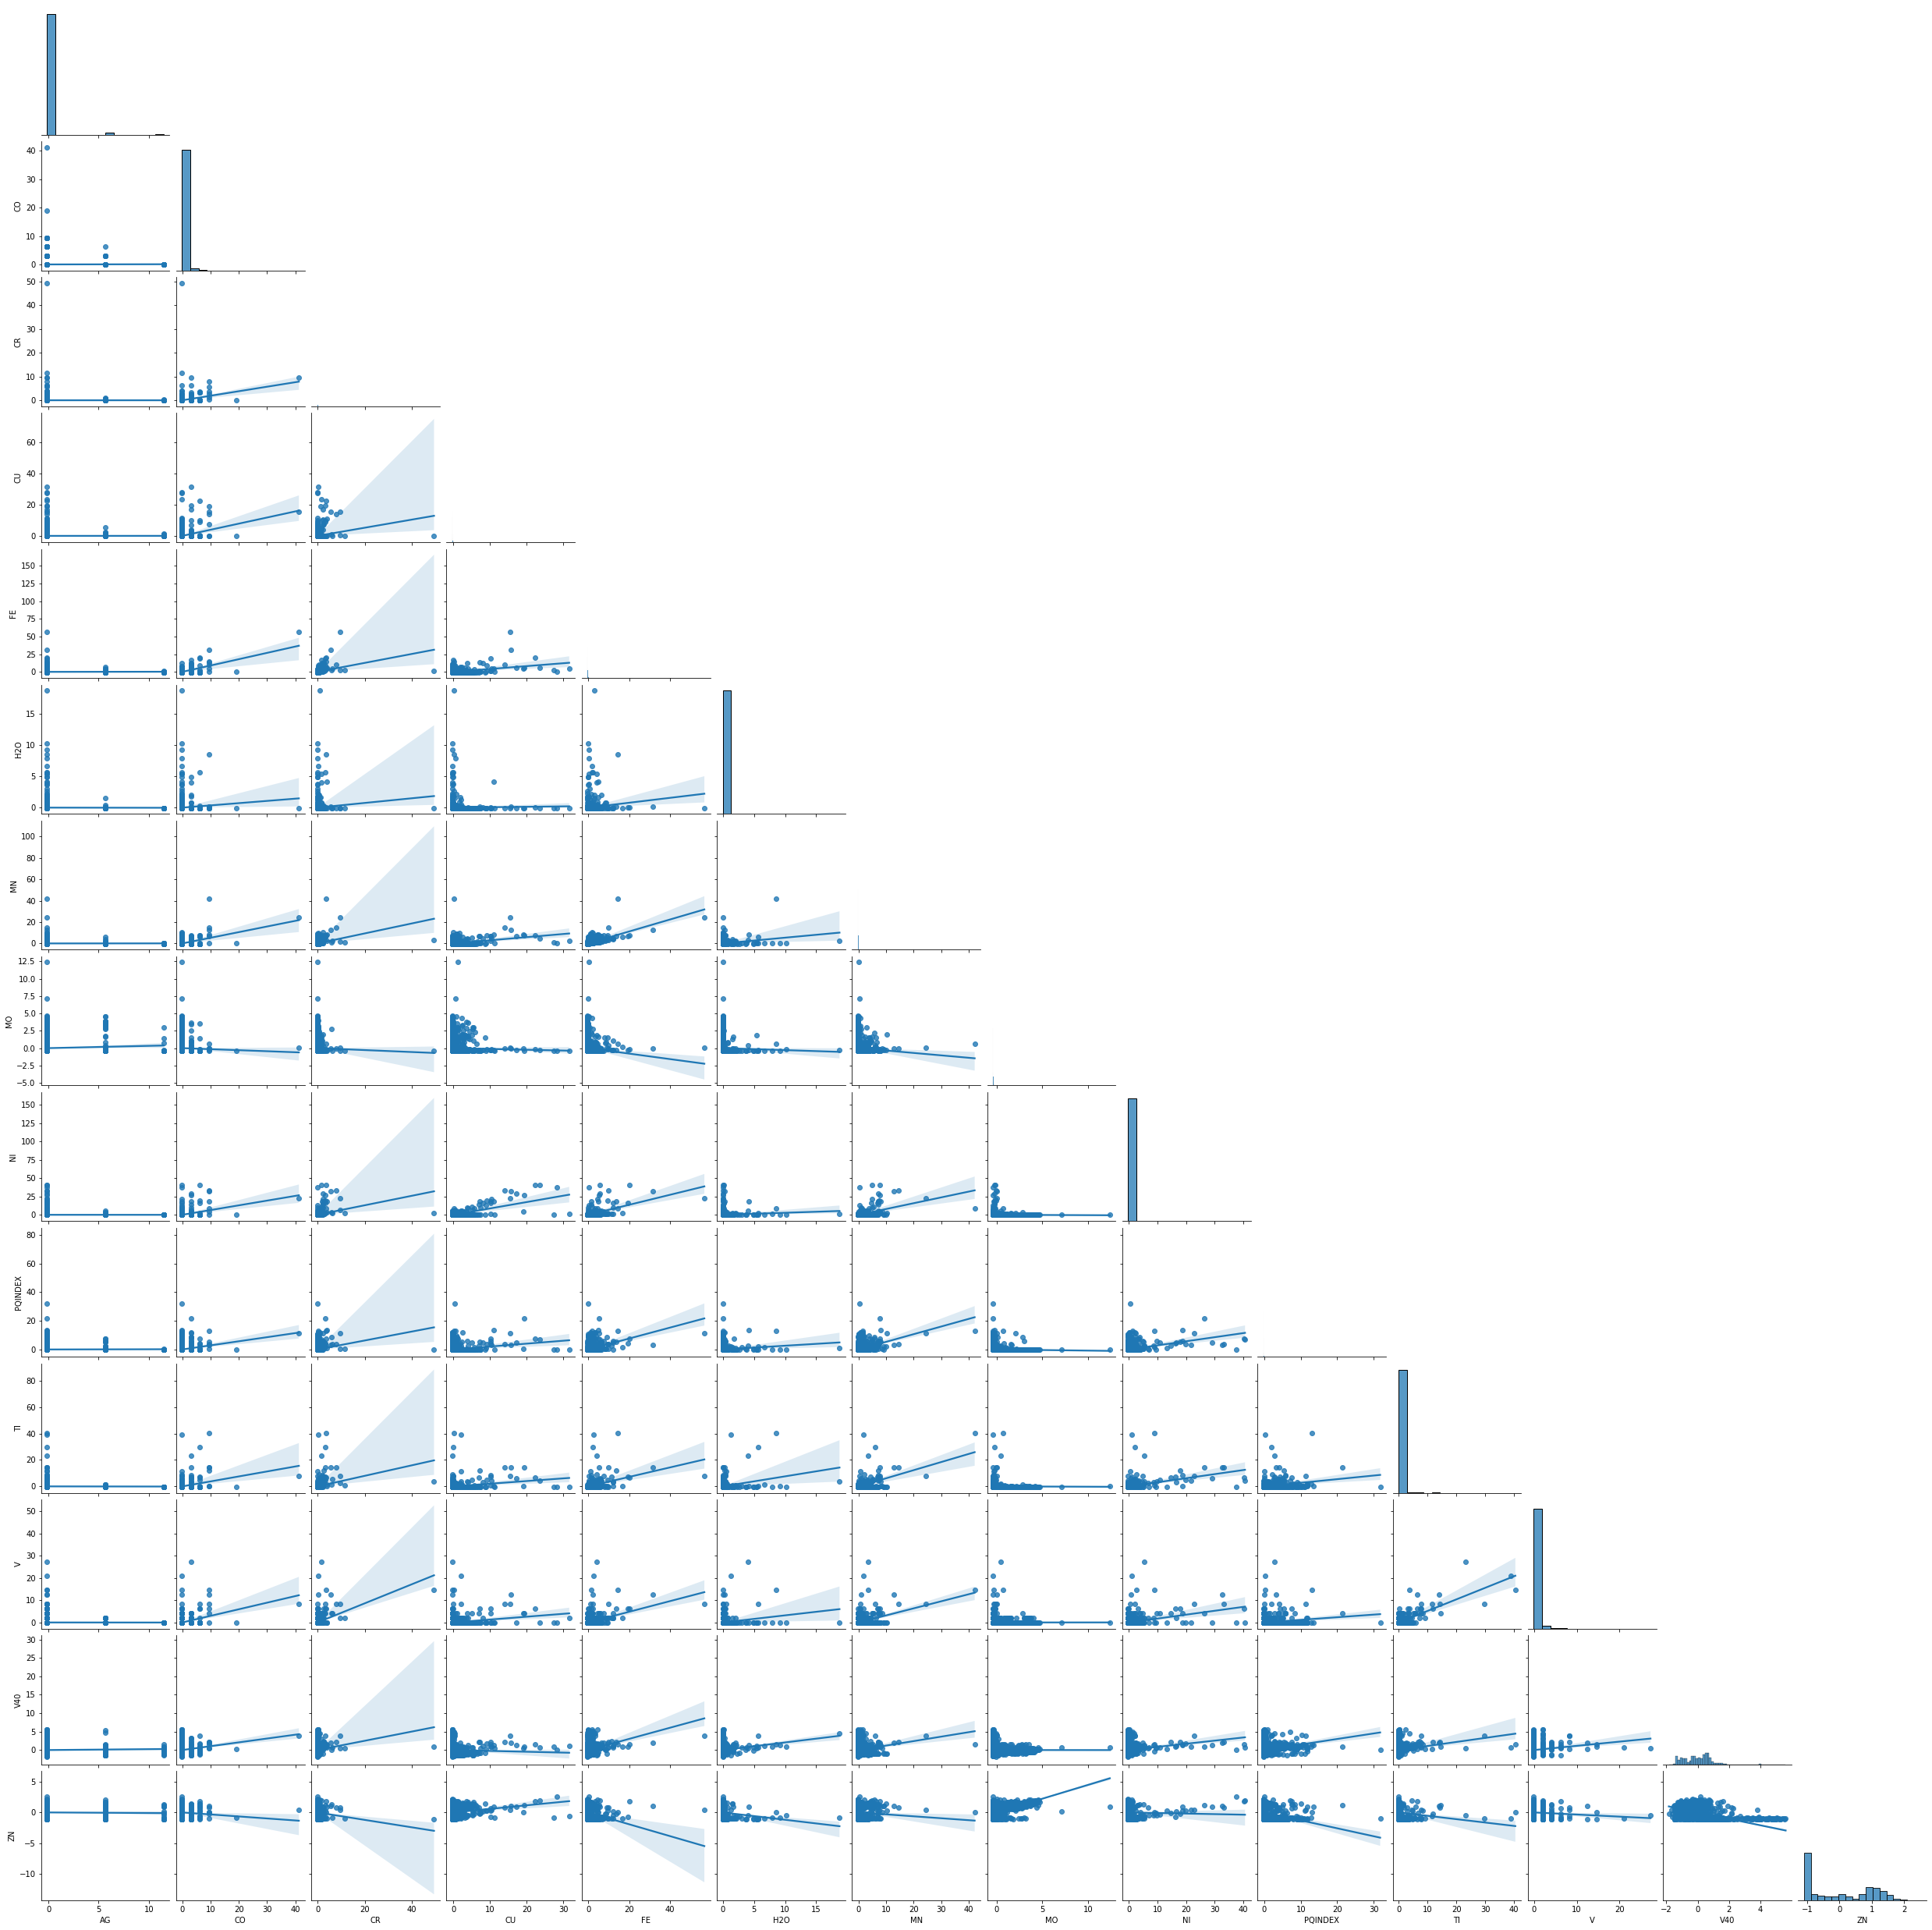

In [798]:
import seaborn as sns
sns.pairplot(data=test[reg_col],kind="reg",corner=True) # reg = 추정회귀선
plt.show()

In [849]:
test.columns

Index(['ANONYMOUS_1', 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN',
       'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN',
       'COMPONENT_ARBITRARY_COMPONENT1', 'COMPONENT_ARBITRARY_COMPONENT2',
       'COMPONENT_ARBITRARY_COMPONENT3', 'COMPONENT_ARBITRARY_COMPONENT4',
       'YEAR_2007', 'YEAR_2008', 'YEAR_2009', 'YEAR_2010', 'YEAR_2011',
       'YEAR_2012', 'YEAR_2013', 'YEAR_2014', 'YEAR_2015', 'YEAR_2016',
       'YEAR_2017', 'YEAR_2018', 'YEAR_2019', 'YEAR_2020', 'YEAR_2021',
       'YEAR_2022'],
      dtype='object')

In [850]:
train_reg.columns

Index(['ANONYMOUS_1', 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN',
       'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN',
       'COMPONENT_ARBITRARY_COMPONENT1', 'COMPONENT_ARBITRARY_COMPONENT2',
       'COMPONENT_ARBITRARY_COMPONENT3', 'COMPONENT_ARBITRARY_COMPONENT4',
       'YEAR_2007', 'YEAR_2008', 'YEAR_2009', 'YEAR_2010', 'YEAR_2011',
       'YEAR_2012', 'YEAR_2013', 'YEAR_2014', 'YEAR_2015', 'YEAR_2016',
       'YEAR_2017', 'YEAR_2018', 'YEAR_2019', 'YEAR_2020', 'YEAR_2021',
       'YEAR_2022'],
      dtype='object')

In [951]:
score_list= []
model = lgb.LGBMRegressor(random_state=CFG['SEED'],**hp3)
model.fit(train_reg,x_target, eval_set = [(train_reg,x_target)],early_stopping_rounds=50) 

pred = model.predict(train_reg)

score = -1*cross_val_score(model, train_reg, pred,cv=cv ,scoring="neg_mean_absolute_error") # cv=cv 지움! # 내가 예측한 값과 실제값의 차이를 계산한 score
score_list.append(score)

[1]	training's l2: 0.0734878
Training until validation scores don't improve for 50 rounds.
[2]	training's l2: 0.0727321
[3]	training's l2: 0.0721273
[4]	training's l2: 0.0716017
[5]	training's l2: 0.0710152
[6]	training's l2: 0.0704962
[7]	training's l2: 0.0700657
[8]	training's l2: 0.0696319
[9]	training's l2: 0.0691949
[10]	training's l2: 0.068847
[11]	training's l2: 0.0684923
[12]	training's l2: 0.0681871
[13]	training's l2: 0.067817
[14]	training's l2: 0.067524
[15]	training's l2: 0.0672402
[16]	training's l2: 0.066947
[17]	training's l2: 0.0665471
[18]	training's l2: 0.0663691
[19]	training's l2: 0.0661135
[20]	training's l2: 0.0657915
[21]	training's l2: 0.0654658
[22]	training's l2: 0.0651943
[23]	training's l2: 0.0649434
[24]	training's l2: 0.0647009
[25]	training's l2: 0.0645068
[26]	training's l2: 0.0642823
[27]	training's l2: 0.0641992
[28]	training's l2: 0.0640536
[29]	training's l2: 0.0638687
[30]	training's l2: 0.0636888
[31]	training's l2: 0.0635505
[32]	training's l2: 0

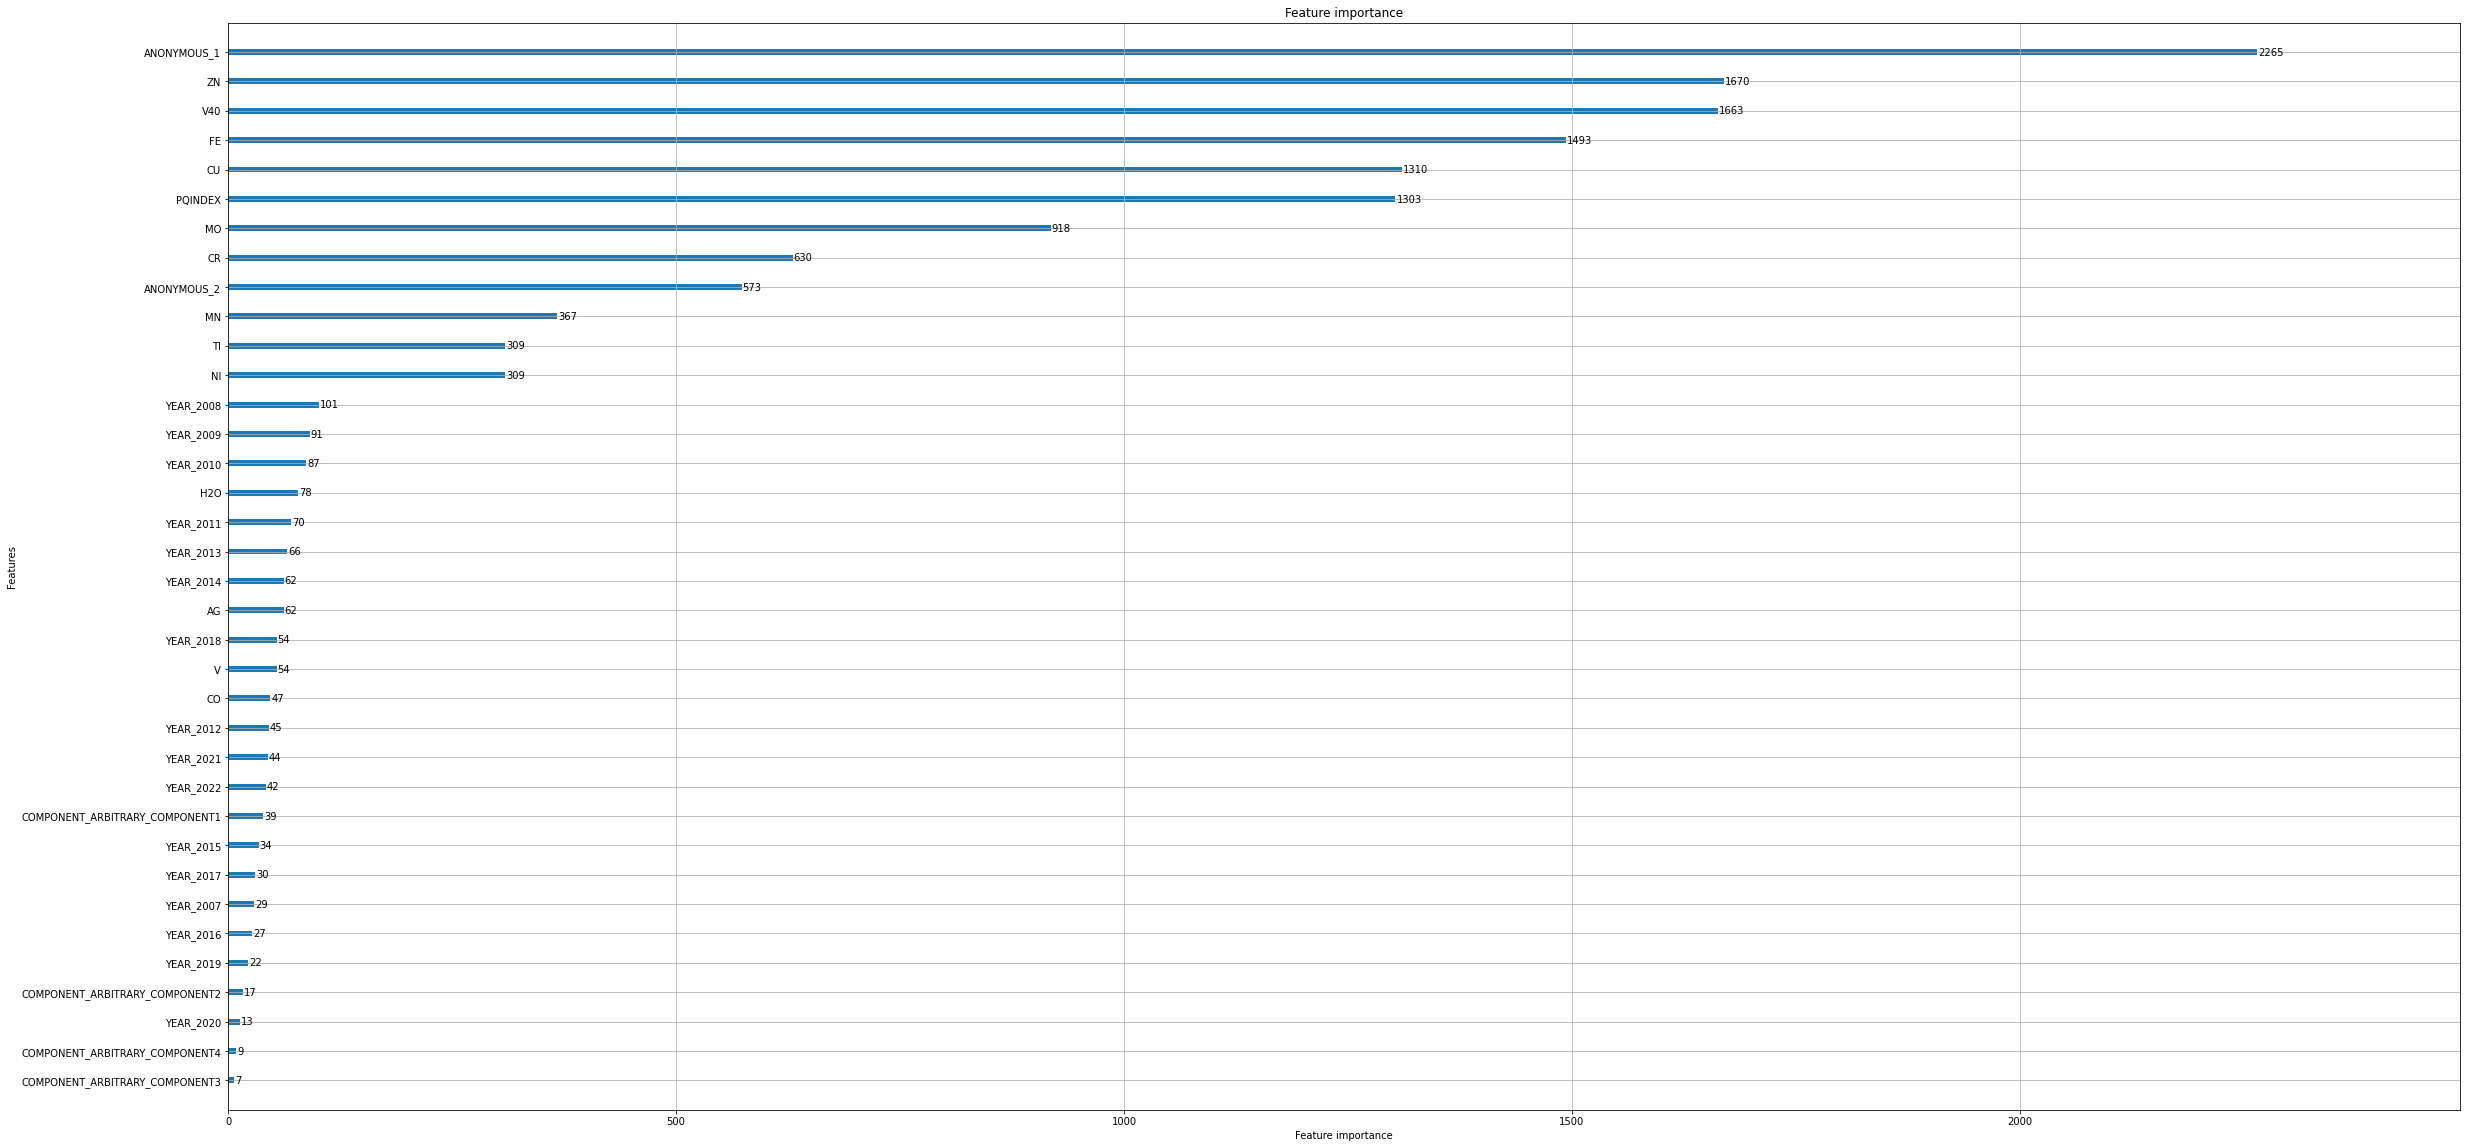

In [852]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(40,20))
plot_importance(model,ax=ax)
plt.show()

In [952]:
np.mean(score_list)
# 0.0886074885785925
# 0.06882263917176783 파라미터 조정
# [0.07241899365301448] f1 score
# [0.07131094591954595] cross_val
# 0.04474295357702526
# 0.057570414759672894

0.057570414759672894

### test의 shape과 맞춘 후 test에 적합

In [953]:
model = lgb.LGBMRegressor(random_state=CFG['SEED'],**hp3)
model.fit(train_reg,x_target)

pred = model.predict(test)

In [954]:
y_pred = pred

In [955]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

In [956]:
submit.Y_LABEL = pd.Series(np.where(y_pred > 0.35, 1, 0)) # 이것도 추후 조정해보기!

In [957]:
submit

,ID,Y_LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
6036,TEST_6036,0
6037,TEST_6037,0
6038,TEST_6038,0
6039,TEST_6039,0


In [958]:
submit.Y_LABEL.value_counts()
# 기존 104

0    5897
1     144
Name: Y_LABEL, dtype: int64

In [959]:
submit.to_csv('/content/drive/MyDrive/submit.csv', index=False)

- 잡다한 것

In [ ]:
# score = f1_score(y_valid, predict,average="macro")
# score = cross_val_score(y_valid, predict, scoring="f1_macro") 

In [ ]:
# score_list = []
    
# # 모델 학습
# model = LGBMClassifier(random_state=42,n_estimators=1000)
# model.fit(train_X,target , eval_set = [(train_X,target)],early_stopping_rounds=50) 

# pred = model.predict_proba(train_X)[:,1] # 1일 확률
# predict = np.where(pred > 0.35, 1 , 0)
# score = f1_score(target,predict,average="macro") 
# score_list.append(score) 

# score_list

In [ ]:
# tpred_list = []
# score_list = []
# for tri,vai in cv.split(test):

#     x_train = test.iloc[tri]
#     y_train = x_target[tri]

#     x_valid = test.iloc[vai]
#     y_valid = x_target[vai]
    

#     model = lgb.LGBMRegressor(random_state=CFG['SEED'],predict_disable_shape_check=True )
#     model.fit(x_train,y_train , eval_set = [(x_valid,y_valid)],early_stopping_rounds=50) 

#     pred = model.predict(x_valid) # 이것을 변환
#     pred_list.append(pred)

# pred_list

In [ ]:
# pred_list = []
# score_list = []

# for tri,vai in cv.split(test_toNum):

#     x_train = test_toNum[tri]
#     y_train = x_target.iloc[tri]

#     x_valid = test_toNum[vai]
#     y_valid = x_target.iloc[vai]

#     model = lgb.LGBMRegressor(random_state=CFG['SEED'],use_missing=False)
#     model.fit(x_train,y_train , eval_set = [(x_train,y_train)],early_stopping_rounds=50) 

#     pred = model.predict(test_toNum)

#     pred_list.append(pred)

#     pred_list

In [ ]:
# pred_list = []
# score_list = []

# for tri,vai in cv.split(train_reg):

#     x_train = train_reg.iloc[tri]
#     y_train = x_target.iloc[tri]

#     x_valid = train_reg.iloc[vai]
#     y_valid = x_target.iloc[vai]
#     model = lgb.LGBMRegressor(random_state=CFG['SEED'])
#     model.fit(x_train,y_train) 

#     pred = model.predict(x_valid)

#     score = mean_absolute_error(y_valid, pred) # 내가 예측한 값과 실제값의 차이를 계산한 score
#     score_list.append(score)
#     pred_list.append(pred)

#     pred_list

In [ ]:
# pred_list = []
# score_list = []
# for tri,vai in cv.split(train_X):

#     x_train = train_X.iloc[tri]
#     y_train = target.iloc[tri]

#     x_valid = train_X.iloc[vai]
#     y_valid = target.iloc[vai]
    
#     model = LGBMClassifier(random_state=CFG['SEED'],**hp) # use_missing=False 결측치 옵션
#     model.fit(x_train,y_train , eval_set = [(x_train,y_train)],early_stopping_rounds=50) 
    
#     pred = model.predict_proba(x_valid)[:,1] # 1일 확률
#     pred_list.append(pred)

#     predict = np.where(pred > 0.35, 1 , 0)
#     score = f1_score(y_valid,predict,average="macro") 
#     score_list.append(score) 

# # np.zero로 1차원 백터를 만들고, vai 순서를 맞게 넣어야한다.
# #     score_list